## Importing Libraries

In [17]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Paths to dataset folders

In [18]:
base_dir = "D:\\Project 2\\chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


## Data Analysis

In [19]:
# Helper function to count images in each class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images in train, val, and test sets
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

Class Distribution in Training Set: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Class Distribution in Validation Set: {'NORMAL': 8, 'PNEUMONIA': 8}
Class Distribution in Test Set: {'NORMAL': 234, 'PNEUMONIA': 390}


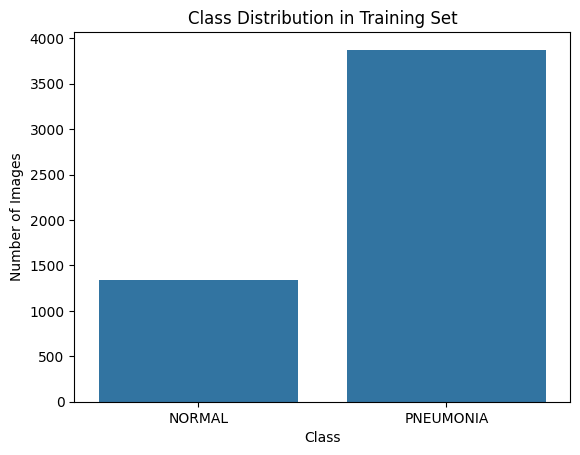

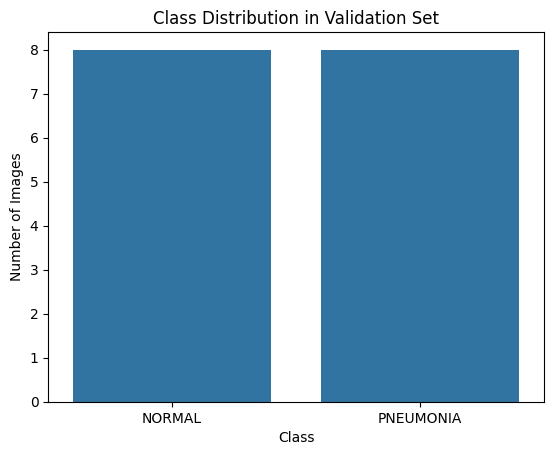

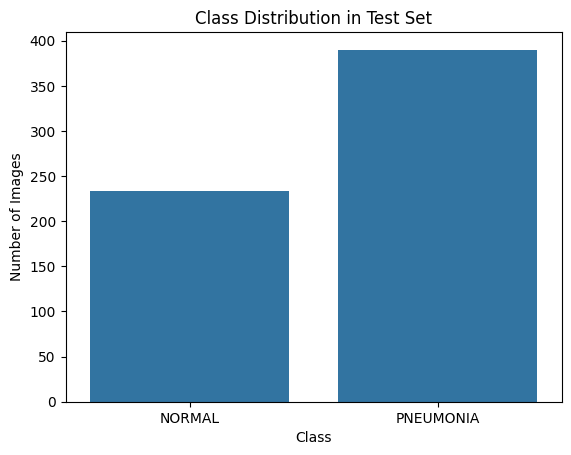

In [20]:
# Plot class distributions
def plot_class_distribution(data, title):
    sns.barplot(x=list(data.keys()), y=list(data.values()))
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.show()

print("Class Distribution in Training Set:", train_counts)
print("Class Distribution in Validation Set:", val_counts)
print("Class Distribution in Test Set:", test_counts)

plot_class_distribution(train_counts, "Class Distribution in Training Set")
plot_class_distribution(val_counts, "Class Distribution in Validation Set")
plot_class_distribution(test_counts, "Class Distribution in Test Set")

## Analyze image properties

In [21]:
def analyze_image_properties(directory):
    image_shapes = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path)
                image_shapes.append(img.size)  # Width x Height
    return image_shapes

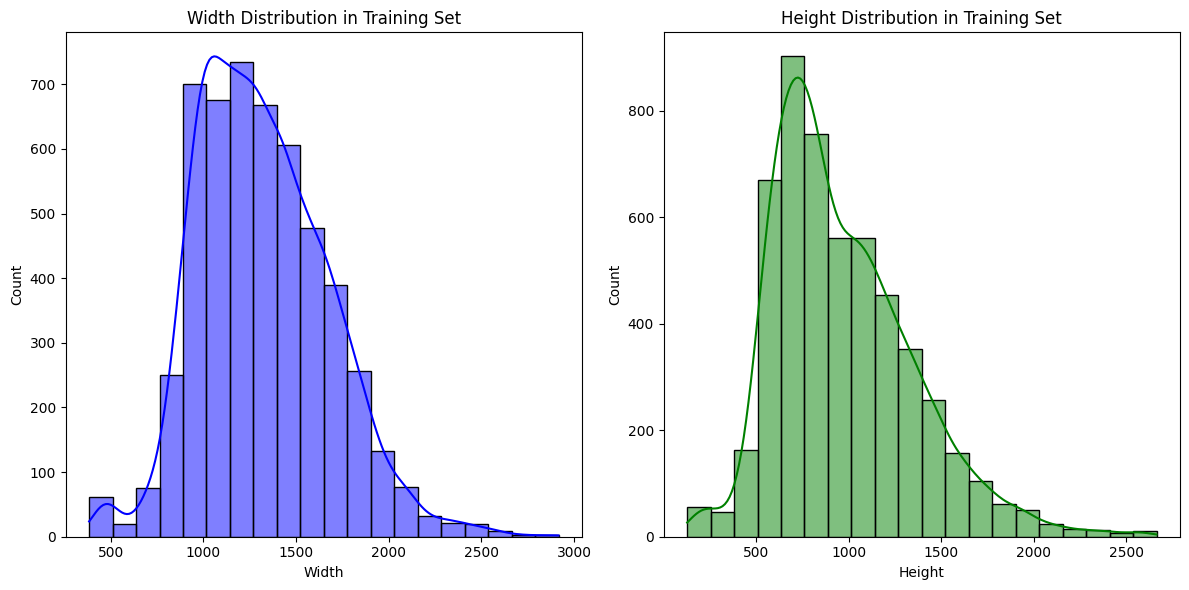

In [22]:
# Get image properties for training set
train_image_shapes = analyze_image_properties(train_dir)
widths, heights = zip(*train_image_shapes)

# Plot image width and height distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20, kde=True, color='blue')
plt.title("Width Distribution in Training Set")
plt.xlabel("Width")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20, kde=True, color='green')
plt.title("Height Distribution in Training Set")
plt.xlabel("Height")

plt.tight_layout()
plt.show()

In [23]:
# Calculate mean, median, and mode of dimensions
print("Mean Image Width:", np.mean(widths))
print("Mean Image Height:", np.mean(heights))
print("Median Image Width:", np.median(widths))
print("Median Image Height:", np.median(heights))
print("Most Common Width and Height:", Counter(train_image_shapes).most_common(1))

Mean Image Width: 1320.6108128834355
Mean Image Height: 968.0747699386503
Median Image Width: 1284.0
Median Image Height: 888.0
Most Common Width and Height: [((1072, 648), 7)]


## Data Augmentation

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,               # Normalize pixel values to [0, 1]
    rotation_range=20,               # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,           # Shift width randomly by up to 20%
    height_shift_range=0.2,          # Shift height randomly by up to 20%
    shear_range=0.2,                 # Apply random shearing
    zoom_range=0.2,                  # Apply random zoom
    horizontal_flip=True             # Randomly flip images horizontally
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only normalize for validation
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only normalize for testing

## Load images from directories

In [25]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize all images to 150x150
    batch_size=32,
    class_mode='binary'      # For binary classification: NORMAL vs PNEUMONIA
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Defining CNN Model

In [26]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

C:\Users\adars\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compiling the Model

In [27]:
# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Training the Model

In [28]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)

C:\Users\adars\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 686ms/step - accuracy: 0.7359 - loss: 0.5995 - val_accuracy: 0.5625 - val_loss: 0.6590
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 661ms/step - accuracy: 0.7919 - loss: 0.4022 - val_accuracy: 0.7500 - val_loss: 0.5463
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 632ms/step - accuracy: 0.8360 - loss: 0.3376 - val_accuracy: 0.7500 - val_loss: 0.6853
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 608ms/step - accuracy: 0.8745 - loss: 0.2706 - val_accuracy: 0.7500 - val_loss: 0.5181
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 614ms/step - accuracy: 0.8855 - loss: 0.2680 - val_accuracy: 0.6250 - val_loss: 0.8243
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 612ms/step - accuracy: 0.8860 - loss: 0.2542 - val_accuracy: 0.8125 - val_loss: 0.4000
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 630ms/step - accuracy: 0.8975 - loss: 0.2403 - val_accuracy: 0.7500 - val_loss: 0.5298
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 634ms/step - accuracy: 0.9017 - 

## Saving the Model

In [29]:
model.save('pneumonia_cnn_model.h5')  # Save the trained model
print("Model saved as 'pneumonia_cnn_model.h5'")


Model saved as 'pneumonia_cnn_model.h5'


## Evaluate on Test Set

In [30]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 709ms/step - accuracy: 0.8747 - loss: 0.3618
Test Accuracy: 85.90%
